In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from IPython.display import display
import spacy
import random
from spacy.tokenizer import Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score

In [51]:
df = pd.read_csv("data/offenseval-training-v1.tsv", delimiter='\t')
df_extra = pd.read_csv("data/agr_en_train.csv", header=None)
df_extra_dev = pd.read_csv("data/agr_en_dev.csv", header=None)

In [52]:
df_extra[2] = df_extra[2].map({'OAG': 1, 'CAG': 1, 'NAG':0})
df_extra_dev[2] = df_extra_dev[2].map({'OAG': 1, 'CAG': 1, 'NAG':0})
df_extra.columns = ["id", "tweet", "subtask_a"]
df_extra_dev.columns = ["id", "tweet", "subtask_a"]
display(df_extra.head())

,id,tweet,subtask_a
0,facebook_corpus_msr_1723796,Well said sonu..you have courage to stand agai...,1
1,facebook_corpus_msr_466073,"Most of Private Banks ATM's Like HDFC, ICICI e...",0
2,facebook_corpus_msr_1493901,"Now question is, Pakistan will adhere to this?",1
3,facebook_corpus_msr_405512,Pakistan is comprised of fake muslims who does...,1
4,facebook_corpus_msr_1521685,"??we r against cow slaughter,so of course it w...",0


In [53]:
print(df.info())
print(df.shape)
print("-----------------")
print("First five rows:")
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 5 columns):
id           13240 non-null int64
tweet        13240 non-null object
subtask_a    13240 non-null object
subtask_b    4400 non-null object
subtask_c    3876 non-null object
dtypes: int64(1), object(4)
memory usage: 517.3+ KB
None
(13240, 5)
-----------------
First five rows:


,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [54]:
df['subtask_a'] = df['subtask_a'].map({'OFF': 1, 'NOT': 0})

### Removal Stop Words

In [55]:
def remove_stop(df):
    sw = stopwords.words('english')
    df['tweet'] = df['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in sw]))

In [56]:
import re
def remove_useless(df):
    # remove @username
    df['tweet'] = df['tweet'].str.replace(r'@[A-Za-z0-9]+','')
    # remove link
    df['tweet'] = df['tweet'].str.replace('https?://[A-Za-z0-9./]+','')
    # remove hashtag
    df['tweet'] = df['tweet'].str.replace(r'\#[A-Za-z0-9]+','')

In [57]:
def preprocess(df):
    remove_stop(df)
    remove_useless(df)
    display(df.head())

In [58]:
preprocess(df)
preprocess(df_extra)
preprocess(df_extra_dev)

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,She ask native Americans take is.,1,UNT,NaN
1,90194,Go home you’re drunk!!! 👊🇺🇸👊 URL,1,TIN,IND
2,16820,Amazon investigating Chinese employees selling...,0,NaN,NaN
3,62688,"Someone should'veTaken"" piece shit volcano. 😂""",1,UNT,NaN
4,43605,Obama wanted liberals &amp; illegals move re...,0,NaN,NaN


,id,tweet,subtask_a
0,facebook_corpus_msr_1723796,Well said sonu..you courage stand dadagiri Mus...,1
1,facebook_corpus_msr_466073,"Most Private Banks ATM's Like HDFC, ICICI etc ...",0
2,facebook_corpus_msr_1493901,"Now question is, Pakistan adhere this?",1
3,facebook_corpus_msr_405512,Pakistan comprised fake muslims know meaning u...,1
4,facebook_corpus_msr_1521685,"??we r cow slaughter,so course stop leather ma...",0


,id,tweet,subtask_a
0,facebook_corpus_msr_451811,The quality made makes think something bought ...,1
1,facebook_corpus_msr_334368,How ur mother??? How ur wife??? How ur sister...,0
2,facebook_corpus_msr_331195,Also see ....hw ur RSS activist caught Burkha ...,0
3,facebook_corpus_msr_403402,On death 2 jawans LOC CROSS FIRING OUR H'BLE H...,0
4,facebook_corpus_msr_379239,Modi ho ya Manmohan singh saala yeh log kuch n...,1


### stemming

In [59]:
stemmer = PorterStemmer()
def stem(df):
    df['tweet'] = df['tweet'].apply(lambda x: x.split())
    # stemmer = PorterStemmer()

    df['tweet'] = df['tweet'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
    df['tweet'] = df['tweet'].apply(lambda x: ' '.join(x))
    display(df.head())
stem(df)
stem(df_extra)
stem(df_extra_dev)

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,she ask nativ american take is.,1,UNT,NaN
1,90194,Go home you’r drunk!!! 👊🇺🇸👊 url,1,TIN,IND
2,16820,amazon investig chines employe sell intern dat...,0,NaN,NaN
3,62688,"someon should'vetaken"" piec shit volcano. 😂""",1,UNT,NaN
4,43605,obama want liber &amp; illeg move red state,0,NaN,NaN


,id,tweet,subtask_a
0,facebook_corpus_msr_1723796,well said sonu..y courag stand dadagiri muslim,1
1,facebook_corpus_msr_466073,"most privat bank atm' like hdfc, icici etc cas...",0
2,facebook_corpus_msr_1493901,"now question is, pakistan adher this?",1
3,facebook_corpus_msr_405512,pakistan compris fake muslim know mean uniti i...,1
4,facebook_corpus_msr_1521685,"??we r cow slaughter,so cours stop leather man...",0


,id,tweet,subtask_a
0,facebook_corpus_msr_451811,the qualiti made make think someth bought fish...,1
1,facebook_corpus_msr_334368,how ur mother??? how ur wife??? how ur sister?...,0
2,facebook_corpus_msr_331195,also see ....hw ur rss activist caught burkha ...,0
3,facebook_corpus_msr_403402,On death 2 jawan loc cross fire our h'ble home...,0
4,facebook_corpus_msr_379239,modi ho ya manmohan singh saala yeh log kuch n...,1


### Task A

/Users/nick/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/api.py:77: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)


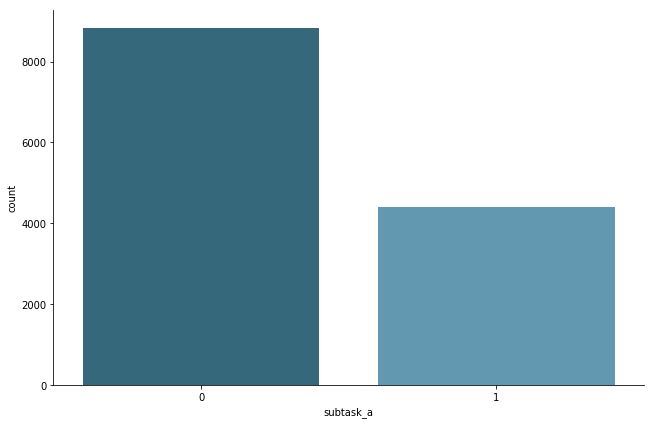

In [60]:
data = list(df['tweet'])
extra = list(df_extra['tweet'])
extra_dev = list(df_extra_dev['tweet'])

df.append(extra)
df.append(extra_dev)
sns.factorplot(x="subtask_a", data=df, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

data.extend(extra)
data.extend(extra_dev)

tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(data)

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

params = {
        'C': [1, 0.1, 0.01,1.1],
        'class_weight': ['balanced'],
        'solver': ('newton-cg', 'sag', 'lbfgs', 'liblinear'),
        'max_iter': [1000]
        }


y = list(df['subtask_a'])
y1 = list(df_extra['subtask_a'])
y2 = list(df_extra_dev['subtask_a'])
y.extend(y1)
y.extend(y2)

grid = GridSearchCV(LogisticRegression(), params, cv=5, verbose=1, n_jobs=-1, scoring='f1_macro')
grid.fit(tfidf, y)

print(grid.best_estimator_)
print(grid.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   12.0s finished


LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
0.690732914646


In [62]:
test_data = pd.read_csv('data/TestA/testset-taska.tsv', delimiter='\t')
preprocess(test_data)
stem(test_data)

,id,tweet
0,15923,"Democrats Support Antifa, Muslim Brotherho..."
1,27014,"revered Conservatives, hated Progressives/Soc..."
2,30530,"First, reduces ca URL"
3,13876,getting news still parole always makes smile...
4,60133,: Unity demo oppose far-right – — Enough En...


,id,tweet
0,15923,"democrat support antifa, muslim brotherhood, m..."
1,27014,"rever conservatives, hate progressives/sociali..."
2,30530,"first, reduc ca url"
3,13876,get news still parol alway make smile. finale....
4,60133,: uniti demo oppos far-right – — enough enough...


In [63]:
test_tfidf = tfidf_vectorizer.transform(test_data['tweet'])


pred = grid.predict(test_tfidf)


id = test_data['id']
result =  np.column_stack((id, pred))
res = pd.DataFrame(result)
res[1] = res[1].map({1:'OFF', 0: 'NOT'})
res.to_csv('result/test_a.csv', index=False, header=False)

### Task B

TIN    3876
UNT     524
Name: subtask_b, dtype: int64


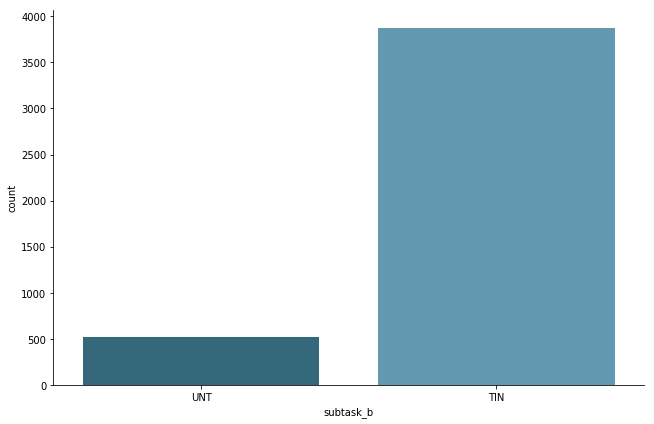

In [64]:
data_b = df[df['subtask_b'].notnull()]
print(data_b['subtask_b'].value_counts())

sns.factorplot(x="subtask_b", data=data_b, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

In [65]:
data_b['subtask_b'] = data_b['subtask_b'].map({'TIN':1, 'UNT':0})
display(data_b.head())

/Users/nick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,she ask nativ american take is.,1,0,NaN
1,90194,Go home you’r drunk!!! 👊🇺🇸👊 url,1,1,IND
3,62688,"someon should'vetaken"" piec shit volcano. 😂""",1,0,NaN
5,97670,liber kookoo !!!,1,1,OTH
6,77444,Oh noes! tough shit.,1,0,NaN


In [66]:
tfidf = tfidf_vectorizer.fit_transform(df['tweet'])
tfidf_b = tfidf_vectorizer.transform(data_b['tweet'])

params = {
        'C': [1, 0.1, 0.01,1.1],
        'class_weight': ['balanced'],
        'solver': ('newton-cg', 'sag', 'lbfgs', 'liblinear'),
        'max_iter': [1000]
        }



grid = GridSearchCV(LogisticRegression(), params, cv=5, verbose=1, n_jobs=-1, scoring='f1_macro')
grid.fit(tfidf_b, data_b['subtask_b'])

print(grid.best_estimator_)
print(grid.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)
0.589202614834


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.4s finished


In [67]:
test_data = pd.read_csv('data/TestB/testset-taskb.tsv', delimiter='\t')
preprocess(test_data)
stem(test_data)

,id,tweet
0,15923,"Democrats Support Antifa, Muslim Brotherho..."
1,60133,: Unity demo oppose far-right – — Enough En...
2,83681,. . . What fuck time?
3,65507,Do get feeling kissing behind humiliate later?
4,12588,Nigga ware da hits


,id,tweet
0,15923,"democrat support antifa, muslim brotherhood, m..."
1,60133,: uniti demo oppos far-right – — enough enough...
2,83681,. . . what fuck time?
3,65507,Do get feel kiss behind humili later?
4,12588,nigga ware da hit


In [68]:
test_tfidf = tfidf_vectorizer.transform(test_data['tweet'])

pred = grid.predict(test_tfidf)


id = test_data['id']
result =  np.column_stack((id, pred))
res = pd.DataFrame(result)
res[1] = res[1].map({1:'TIN', 0: 'UNT'})
res.to_csv('result/test_b.csv', index=False, header=False)

### Task C

IND    2407
GRP    1074
OTH     395
Name: subtask_c, dtype: int64
(3876, 5)


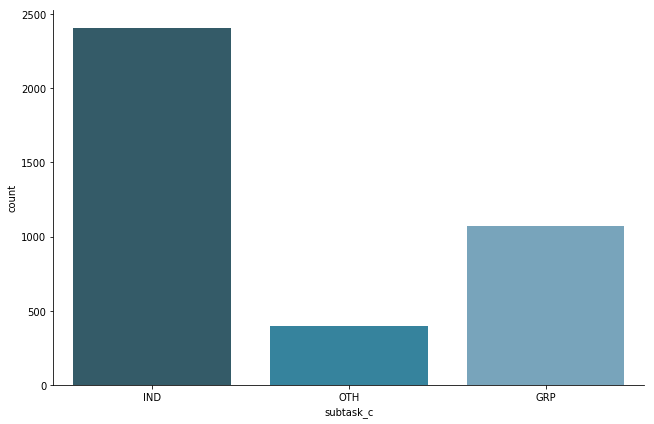

In [69]:
data_c = df[df['subtask_c'].notnull()]
print(data_c['subtask_c'].value_counts())
print(data_c.shape)

sns.factorplot(x="subtask_c", data=data_c, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

In [70]:
data_c['subtask_c'] = data_c['subtask_c'].map({'IND':0, 'GRP':1, 'OTH':2})
display(data_c.head())

/Users/nick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,id,tweet,subtask_a,subtask_b,subtask_c
1,90194,Go home you’r drunk!!! 👊🇺🇸👊 url,1,TIN,0
5,97670,liber kookoo !!!,1,TIN,2
7,52415,liter talk lol mass shoot like set ups. it’ pr...,1,TIN,1
9,13384,canada doesn’t need anoth cuck! We alreadi eno...,1,TIN,0
12,28414,lie corrupt traitor!!! nobodi want hear anymor...,1,TIN,0


In [71]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import cross_val_score


tfidf = tfidf_vectorizer.fit_transform(df['tweet'])
tfidf_c = tfidf_vectorizer.transform(data_c['tweet'])

lr = LogisticRegression(class_weight='balanced')

ovo = OneVsOneClassifier(lr)



scores = cross_val_score(ovo, tfidf_c, data_c['subtask_c'], cv=5, scoring='f1_macro')
print(scores.mean())


0.495729652711


In [72]:
test_data = pd.read_csv('data/TestC/test_set_taskc.tsv', delimiter='\t')
preprocess(test_data)
stem(test_data)

,id,tweet
0,15923,"Democrats Support Antifa, Muslim Brotherho..."
1,60133,: Unity demo oppose far-right – — Enough En...
2,83681,. . . What fuck time?
3,65507,Do get feeling kissing behind humiliate later?
4,34263,liar like rest URL


,id,tweet
0,15923,"democrat support antifa, muslim brotherhood, m..."
1,60133,: uniti demo oppos far-right – — enough enough...
2,83681,. . . what fuck time?
3,65507,Do get feel kiss behind humili later?
4,34263,liar like rest url


In [73]:
test_tfidf = tfidf_vectorizer.transform(test_data['tweet'])

pred = grid.predict(test_tfidf)


id = test_data['id']
result =  np.column_stack((id, pred))
res = pd.DataFrame(result)
res[1] = res[1].map({1:'GRP', 0: 'IND', 2:'OTH'})
res.to_csv('result/test_c.csv', index=False, header=False)